## TimSim DDA 

This notebook breaks down the current `timsim` cmd tool into its core components. It creates a playground for the implementation of a simulated DDA acquisition. After generating a synthetic DDA dataset, we will use `sagepy` to see how simulated data can be used for benchmarking.

### Step 1: Create a new synthetic experiment 

We start by setting up the required databases and raw files, allowing interaction with three core datasets:

```text
EXAMPLE/
├── EXAMPLE.d/
│   ├── analysis.tdf         ← SQLite metadata database (Bruker format)
│   └── analysis.tdf_bin     ← Binary frames (Bruker format)
└── synthetic_data.db        ← Simulation blueprint (custom)
```

- `analysis.tdf`: SQLite database in a `.d` folder, simulating metadata for a timsTOF raw dataset  
- `analysis.tdf_bin`: Binary block holding raw frames, initially empty  
- `synthetic_data.db`: SQLite database storing a simulation blueprint with tables describing ion distributions

In [1]:
from imspy.simulation.timsim.jobs.build_acquisition import build_acquisition

# give a path to a reference dataset (real data TDF folder)
ref_path = "/media/hd01/CCSPred/HELA-GRAD110/M210115_001_Slot1-1_1_850.d/"

# give a path where data will be put into
save_path = "."

# 30 minutes gradient
gradient_length = 30 * 60

# helper function that sets up paths and creates a handle that can connect to the real bruker dataset,
# the simulated bruker dataset, and the simulation blueprint
acquisition_builder = build_acquisition(
    path=save_path,
    reference_path=ref_path,
    exp_name="T002",
    # set acquisition type to DDA
    acquisition_type='DDA',
    verbose=False,
    # gradient length should be given in seconds
    gradient_length=gradient_length,
)

2025-04-25 08:44:06.731252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 08:44:06.731288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 08:44:06.732505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 08:44:06.738494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 08:44:07.328715: W tensorflow/compiler/tf2

Connecting to database: T002/synthetic_data.db


### Step 2: Create proteins table where peptides will be sampled from
Next, a set of proteins is sampled from a given FASTA file and synthetically digested and associated with an occurence value.
In the long run, this step will offer more options for how peptides are sampled from proteins and how to define the occurence; for now, sampling is done randomly and occurence sampling is done using a custom hokey-stick distribution which we derived experimentally.

In [2]:
from imspy.simulation.timsim.jobs.simulate_proteins import simulate_proteins

# create collection of proteins, create peptides to be taken from proteins
proteins = simulate_proteins(
    fasta_file_path="/media/hd02/data/fasta/hela/plain/hela.fasta",
    # if requested num proteins is larger than number of proteins in file, take all
    n_proteins=20000,
    cleave_at="KR",
    restrict="P",
    missed_cleavages=2,
    min_len=7,
    # max length is currently dictated by prosit intensity predictor maximum
    max_len=30,
    generate_decoys=False,
    # request modifications UNIMOD style
    variable_mods={"[": ["[UNIMOD:1]"]},
    static_mods={"C": "[UNIMOD:4]"},
    verbose=True,
)

### Step 3: Create peptides table 
Next, a collection of peptides is generated. When randomly sampling peptides from a synthetic digest, many of the selected peptides may have very low predicted retention times, leading to an imbalance in the distribution and increasing the workload when building frames later.
To address this, the peptide table generation step allows for balancing peptide occurrences across the retention time gradient of the experiment.

In [3]:
from imspy.simulation.timsim.jobs.simulate_peptides import simulate_peptides

# simulate peptides
peptides = simulate_peptides(
    protein_table=proteins,
    num_peptides_total=50_000,
    verbose=True,
    exclude_accumulated_gradient_start=True,
    min_rt_percent=2.0,
    gradient_length=acquisition_builder.gradient_length,
    down_sample=True,
    proteome_mix=False,
)

Simulating retention times for peptides and filtering...


2025-04-25 08:44:47.504114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-25 08:44:47.545719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-25 08:44:47.549084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Excluded 0 peptides with low retention times.


In [4]:
# extract relevant columns from proteins
proteins = proteins[["protein_id", "protein", "sequence", "events"]]
# Save proteins to sqlite table
acquisition_builder.synthetics_handle.create_table(table_name='proteins', table=proteins)

### Step 4: Predict retention times for peptides

After the peptides are selected, their retention times are simulated using a neural network.
In the long run, it would be ideal to design the simulator in a way that allows models to be easily swapped out.

In [5]:
from imspy.simulation.timsim.jobs.simulate_retention_time import simulate_retention_times

peptides = simulate_retention_times(
    peptides=peptides,
    verbose=True,
    gradient_length=acquisition_builder.gradient_length,
)

columns = list(peptides.columns)
# The last two might be 'events' and 'retention_time_gru_predictor' or some similar swap:
columns[-2], columns[-1] = columns[-1], columns[-2]
peptides = peptides[columns]

Simulating retention times...
37/37 [==============================] - 1s 14ms/step


### Step 5: Create a full retention time distribution

Predicting point estimates for retention times is not sufficient.
Peptides need to be represented by full distributions in the retention time dimension, modeled here using an Exponentially Modified Gaussian (EMG) distribution.
This step provides a few hyperparameters to introduce slight variability into the individual distributions.

In [6]:
from imspy.simulation.timsim.jobs.simulate_frame_distributions_emg import simulate_frame_distributions_emg

peptides = simulate_frame_distributions_emg(
    peptides=peptides,
    frames=acquisition_builder.frame_table,
    rt_cycle_length=acquisition_builder.rt_cycle_length,
    target_p=0.9999,
    step_size=0.001,
    sigma_alpha_rt=4,
    sigma_beta_rt=4,
    k_lower_rt=0,
    k_upper_rt=10,
    k_alpha_rt=1,
    k_beta_rt=20,
    verbose=True,
    add_noise=False,
    num_threads=16,
    from_existing=False,
    sigmas=None,
    lambdas=None,
    sigma_lower_rt=None,
    sigma_upper_rt=None,
    gradient_length=gradient_length,
)

# After the full distributions are created, the peptides table can be saved to the sqlite database
acquisition_builder.synthetics_handle.create_table(table_name='peptides', table=peptides)

Calculating frame distributions...
sigma_lower: 1.125, sigma_upper: 1.875, sigma_alpha: 4, sigma_beta: 4
Serializing frame distributions to json...


### Step 6: Synthetically ionize, mobility-separate, and distribute peptides

Following the same approach used to generate retention time distributions, the next steps combine machine learning models and distribution-based calculations to produce an ions table.
For conciseness, these operations are grouped into a single step.

In [7]:
from imspy.simulation.timsim.jobs.simulate_charge_states import simulate_charge_states
from imspy.simulation.timsim.jobs.simulate_ion_mobilities_and_variance import simulate_ion_mobilities_and_variance
from imspy.simulation.timsim.jobs.simulate_precursor_spectra import simulate_precursor_spectra_sequence
from imspy.simulation.timsim.jobs.simulate_scan_distributions_with_variance import simulate_scan_distributions_with_variance

# create charge states
ions = simulate_charge_states(
    peptides=peptides,
    mz_lower=acquisition_builder.tdf_writer.helper_handle.mz_lower,
    mz_upper=acquisition_builder.tdf_writer.helper_handle.mz_upper,
    p_charge=0.5,
    max_charge=4,
    use_binomial=False,
    min_charge_contrib=0.05,
)

# get ion-mobilities and variances
ions = simulate_ion_mobilities_and_variance(
    ions=ions,
    im_lower=acquisition_builder.tdf_writer.helper_handle.im_lower,
    im_upper=acquisition_builder.tdf_writer.helper_handle.im_upper,
    verbose=True,
    remove_mods=True,
    use_target_mean_std=True,
    target_std_mean=0.006,
)

# get precursor isotopic distributions
ions = simulate_precursor_spectra_sequence(
    ions=ions,
    num_threads=16,
    verbose=True,
)

# get scan distributions total
ions = simulate_scan_distributions_with_variance(
    ions=ions,
    scans=acquisition_builder.scan_table,
    verbose=True,
    p_target=0.9999,
    add_noise=False,
    num_threads=16,
)

# save ions
acquisition_builder.synthetics_handle.create_table(table_name='ions', table=ions)

37/37 [==============================] - 1s 15ms/step


flatmap charges: 100%|█████████████████| 37784/37784 [00:01<00:00, 22272.10it/s]


Simulating ion mobilities and variance...
55/55 [==============================] - 2s 27ms/step
Standard deviation distribution apex was shifted from 0.0058 to 0.0090
Simulating sequence specific precursor isotopic distributions ...
Serializing simulated spectra to json...
Calculating scan distributions...
Calculating scan occurrences...
Calculating scan abundances...
Serializing scan distributions to json...


### Simulate dda-PASEF Selection Scheme
In DDA mode, precursors are selected based on an online selection scheme, often topN intensity, that samples ions constantly arriving from the LC. To simulate this process, we need to mimic this behaviour, creating two tables:

* Precursors table, giving information about the selected Precursor ions (mz, charge, top intensity mz, etc.)
* PASEFmeta table, holding quadrupole settings and collision energies

The simulation tool offers two selection modes out-of-the-box, `topN` and `random`, where random simply picks precursors above some intensity threshold at random instead of sorting them by intensity and then taking the topN ones.

In [8]:
from imspy.simulation.timsim.jobs.dda_selection_scheme import simulate_dda_pasef_selection_scheme

pasef_meta, precursors = simulate_dda_pasef_selection_scheme(
    acquisition_builder, 
    precursors_every=4, 
    intensity_threshold=1000, 
    max_precursors=25, 
    verbose=False,
    selection_mode="topN",
)

Selecting precursors: 100%|████████████████| 4129/4129 [00:21<00:00, 194.71it/s]
/home/administrator/Documents/promotion/rust/rustims/imspy/imspy/simulation/timsim/jobs/dda_selection_scheme.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pasef_meta_df = pd.concat(pasef_meta_list)
/home/administrator/Documents/promotion/rust/rustims/imspy/imspy/simulation/timsim/jobs/dda_selection_scheme.py:120: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  precursors_df = pd.concat(precursors_list)


### Come up with your own DDA Mode!

You can easily replace the provided procedures with your own ones. You need to implement a procedure that gets as input a simulated precursor frame and selects from it some precursors as well as doing a feature detection, and then a procedure to write the meta data table holding the information about the quadrupole settings.

**The precursor table must define for each selected precursor**:
* id
* largest_peak_mz, the mz with highest intensity 
* average_mz, average mz of the isotopic envelope
* monoisotopic_mz, monoisotopic mz of the isotopic envelope
* charge or None, if charge state cannot be determined
* scan_number the precursor had its apex
* sum intensity over all peaks precursor had in this frame
* parent, the frame id the precursor was identified in

**The pasef_meta table must define, for each fragment frame, the quadrupole settings to be applied. Each row must include**:
* scan_start, quadrupole scan selection start
* scan_end, quadrupole scan selection end
* quad_window_midpoint, the mz isolation midpoint
* quad_window_length, the size of the mz selection window (often 2.0 or 3.0 Da)
* collision_energym the applied collision energy
* precursor_id (used to trace back which precursor was selected for fragmentation from the preceding MS1 frame)

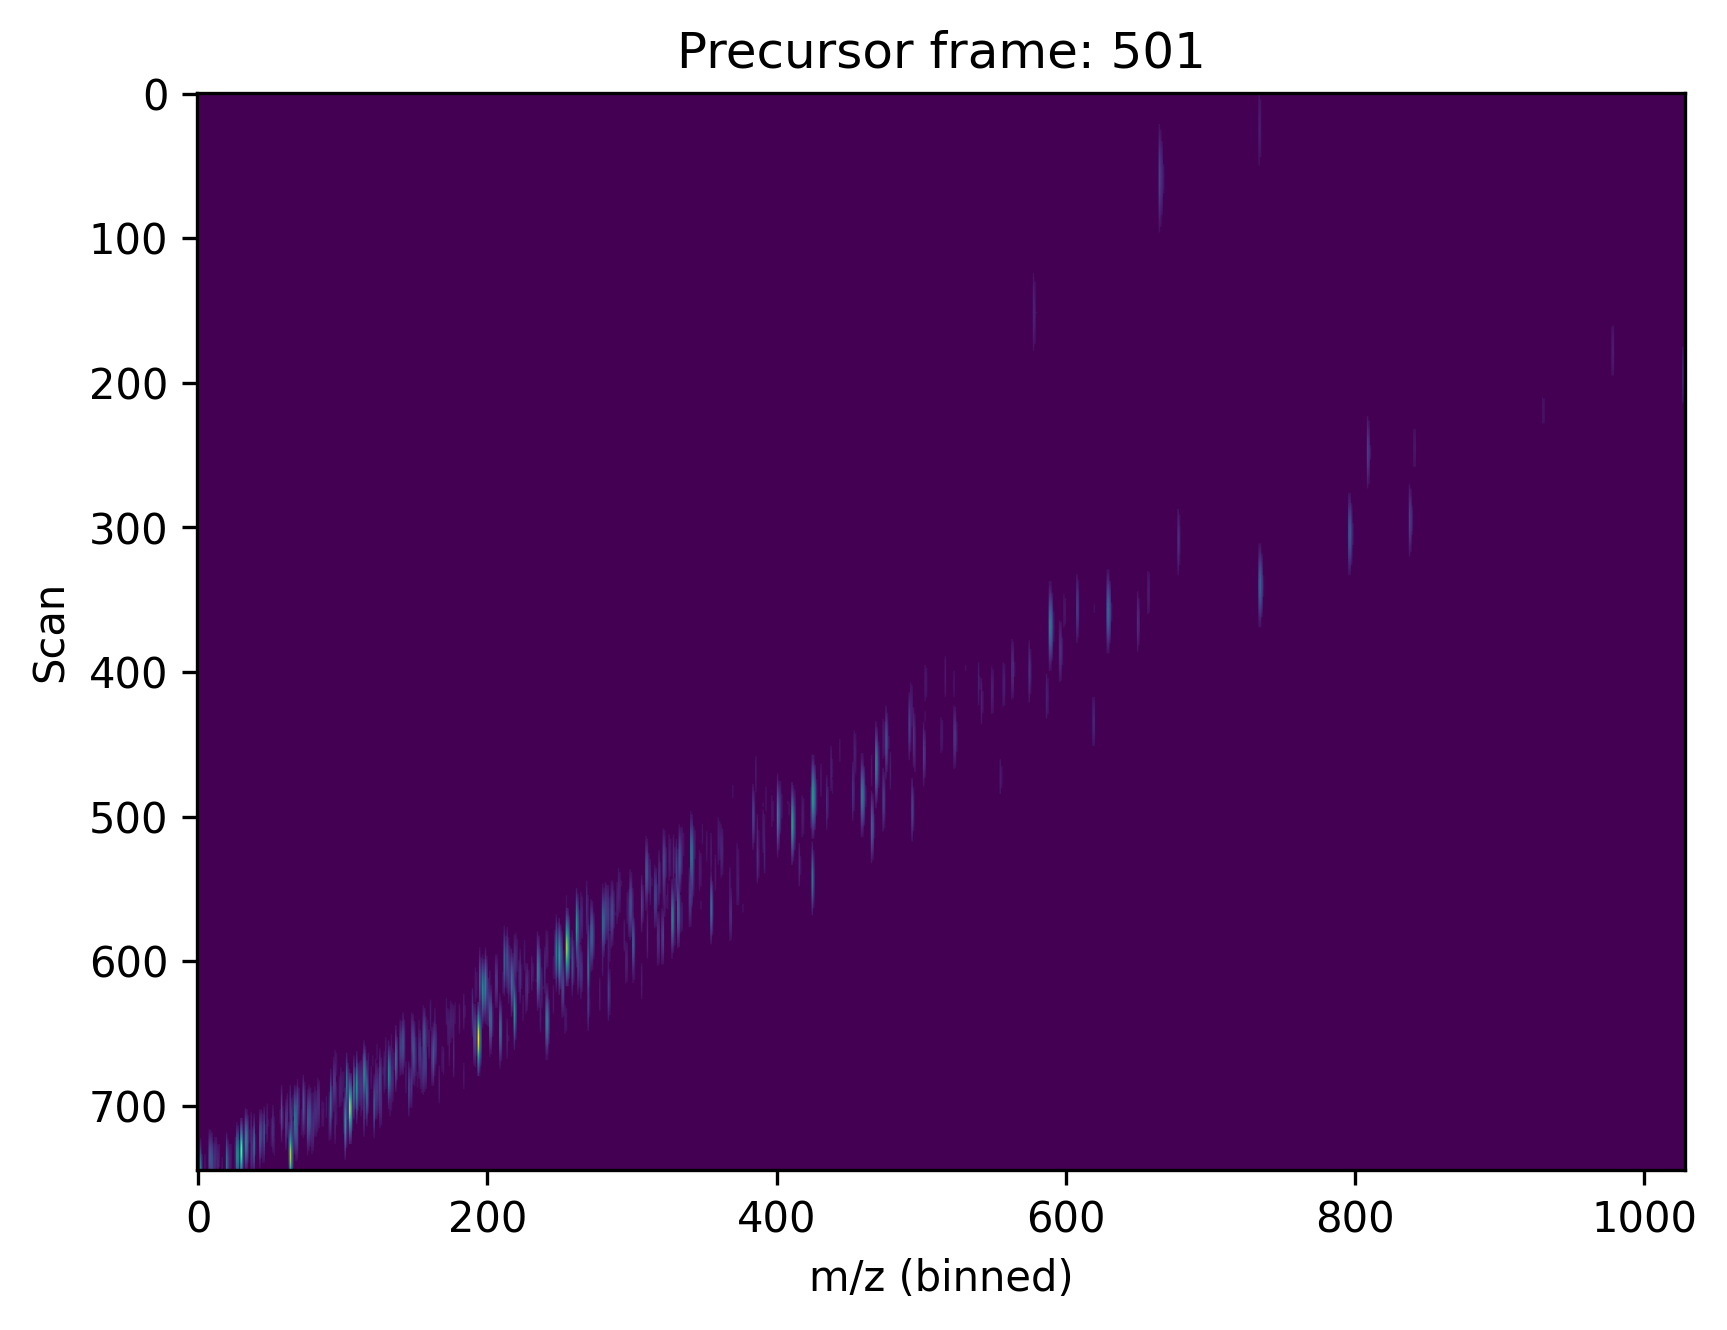

In [112]:
from imspy.simulation.experiment import TimsTofSyntheticPrecursorFrameBuilder

# one option is to use the precursor frame builder, create the precursor frames, and do the feature detection there
precursor_frame_builder = TimsTofSyntheticPrecursorFrameBuilder("T002/synthetic_data.db")
pid = 501
frame = precursor_frame_builder.build_precursor_frame(pid)

# have a look how the simulated precursor frame looks like
M = frame.vectorized(0).get_tensor_repr(zero_indexed=True, re_index=False, dense=True).numpy()

plt.figure(dpi=300)
plt.imshow(np.cbrt(M))
plt.title(f"Precursor frame: {pid}")
plt.ylabel("Scan")
plt.xlabel("m/z (binned)")
plt.show()

### Save the generated selection to disk


In [9]:
# using the handle to the blueprint, we can insert the new pasef_meta table directly
acquisition_builder.synthetics_handle.create_table("pasef_meta", table=pasef_meta)

# using the handle to the blueprint, we can insert the new pasef_meta table directly
acquisition_builder.synthetics_handle.create_table("precursors", table=precursors)

### Simulate Fragment Ion Intensities

Now that we have a collection of quadrupole settings to apply to the precursor space, we can determine which precursor ions are actually selected from the simulated ion population.

This step was introduced to improve simulation efficiency — without it, a large amount of fragmentation data would be simulated unnecessarily for ions that are never selected for fragmentation.

Only after this selection step is performed can we proceed to simulate the fragment frames.

In [10]:
from imspy.simulation.timsim.jobs.simulate_fragment_intensities import simulate_fragment_intensities

# JOB 9: Simulate fragment intensities
simulate_fragment_intensities(
    # TODO: clean up this mess dealing with paths like a madman...
    path=".",
    name="T002",
    acquisition_builder=acquisition_builder,
    batch_size=256,
    verbose=True,
    num_threads=16,
    down_sample_factor=.5,
    dda=True
)

Simulating fragment ion intensity distributions...
Calculating precursor ion transmissions and collision energies...


Simulating intensities: 100%|█████████████████████████████████████████| 2/2 [00:41<00:00, 20.77s/it]


Mapping fragment ion intensity distributions to b and y ions...


flattening prosit predicted intensities: 100%|██████████████████████| 10/10 [03:46<00:00, 22.61s/it]


### Create the TDF Dataset

Everything is now set-up for the full simulation, generating the synthetic TDF that can be passed to other software afterwards.

In [11]:
from imspy.simulation.timsim.jobs.assemble_frames import assemble_frames

# Assemble frames, write the frames to a synthetic TDF file
assemble_frames(
    acquisition_builder=acquisition_builder,
    frames=acquisition_builder.frame_table,
    batch_size=512,
    verbose=False,
    mz_noise_precursor=True,
    mz_noise_uniform=True,
    precursor_noise_ppm=5.0,
    mz_noise_fragment=True,
    fragment_noise_ppm=5.0,
    num_threads=16,
    add_real_data_noise=False,
    intensity_max_precursor=1500,
    intensity_max_fragment=1500,
    precursor_sample_fraction=0.2,
    fragment_sample_fraction=0.2,
    num_precursor_frames=5,
    num_fragment_frames=5,
    fragment=True,
)

frame assembly: 100%|███████████████████████████████████████████████| 33/33 [11:41<00:00, 21.25s/it]


### Possible Downstream Analysis: Evaluate True FDR calculation of SAGE using sagepy

The finished simulation results in a TDF and a simulation meta data database. Using functionality described in our recent [rusims](https://pubs.acs.org/doi/10.1021/acs.jproteome.4c00966) publication, we can for example use SAGE through sagepy for generating PSMs and evaluating true FDR rates since we have ground truth about simulatet peptides.


### Load the Data

In [12]:
import numpy as np
from imspy.timstof.dda import TimsDatasetDDA
from imspy.simulation.acquisition import SyntheticExperimentDataHandle

# create a data handle to the RAW data
ds_name = "T002"
data = TimsDatasetDDA("T002/T002.d")
fragments = data.get_pasef_fragments()

# this data lacks summarized ion-mobility information (point estimate), which can be extracted and added to the df
mobility = fragments.apply(lambda r: r.raw_data.get_inverse_mobility_along_scan_marginal(), axis=1)
fragments['mobility'] = mobility

# also, add a spectrum id for processing of spectra with 
spec_id = fragments.apply(lambda r: str(r['frame_id']) + '-' + str(r['precursor_id']) + '-' + ds_name, axis=1)
fragments['spec_id'] = spec_id

# create a database handle to the simulation meta data database
handle = SyntheticExperimentDataHandle("T002/")
SIM_peptides = handle.get_table("peptides")

/home/administrator/Documents/promotion/rust/rustims/imspy/imspy/timstof/dda.py:161: UserWarning: Using multiple threads is currently not supported when using Bruker SDK, setting num_threads to 1.
  warnings.warn("Using multiple threads is currently not supported when using Bruker SDK, "


Connecting to database: T002/synthetic_data.db


### Create Sage compatible Spectra for PSM generation

In [52]:
from imspy.timstof.dbsearch.utility import sanitize_mz, sanitize_charge, get_searchable_spec
from sagepy.core import Precursor, RawSpectrum, ProcessedSpectrum, SpectrumProcessor, Tolerance, Scorer, Representation

# create a precursor object
sage_precursor = fragments.apply(lambda r: Precursor(
    mz=sanitize_mz(r['monoisotopic_mz'], r['largest_peak_mz']), 
    intensity=r['intensity'],
    charge=sanitize_charge(r['charge']),
    isolation_window=Tolerance(da=(-3, 3)),
    collision_energy=r.collision_energy,
    inverse_ion_mobility=r.mobility,
), axis=1)

# add the precursor object to the df
fragments['sage_precursor'] = sage_precursor

# create a searchable fragment spectrum, which is a combination of the precursor info and fragment spectrum
processed_spec = fragments.apply(
    lambda r: get_searchable_spec(
        precursor=r.sage_precursor,
        raw_fragment_data=r.raw_data,
        spec_processor=SpectrumProcessor(take_top_n=150, deisotope=True),
        spec_id=r.spec_id,
        time=r['time'],
    ),
    axis=1
)

# add the spectra to the data frame
fragments['processed_spec'] = processed_spec

### Create a SAGE Database

In [53]:
from sagepy.core import EnzymeBuilder

# configure a trypsin-like digestor of fasta files
enzyme_builder = EnzymeBuilder(
    missed_cleavages=2, 
    min_len=7,
    max_len=30,
    cleave_at='KR', 
    restrict='P',
    c_terminal=True,
)

# Static modifications
static_modifications = {
    "C": "[UNIMOD:4]",
}

# Variable mods need to take a list
variable_modifications = {
    "M": ["[UNIMOD:35]"],
    "[": ["[UNIMOD:1]"]
}

# read a reference fasta file of a proteome, in this case human proteome since this tutorial used HeLa data
path = '/media/hd02/data/fasta/hela/plain/hela.fasta'

with open(path, 'r') as infile:
    fasta = infile.read()

import numpy as np
from sagepy.core import SageSearchConfiguration

# set-up a config for a sage-database
sage_config = SageSearchConfiguration(
    fasta=fasta,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
    enzyme_builder=enzyme_builder,
    generate_decoys=True,
    bucket_size=int(np.power(2, 14)),
    keep_ends=True,
    shuffle_decoys=False,
)

# generate the database for searching against
indexed_db = sage_config.generate_indexed_database()

### Create a Scorer and Score the Spectra to generate PSMs

In [79]:
from sagepy.utility import psm_collection_to_pandas

# create a scorer object that can be used to search a database given a collection of spectra to search
scorer = Scorer(
    # since we set precursor and fragment noise to 5 ppm, we will configure the scorer as follows:
    precursor_tolerance=Tolerance(ppm=(-10.0, 10.0)),
    fragment_tolerance=Tolerance(ppm=(-8.0, 8.0)),
    report_psms=5,
    min_matched_peaks=5,
    annotate_matches=True,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
)


# scoring the results
psm_collection = scorer.score_collection_psm(
    db=indexed_db, 
    spectrum_collection=fragments['processed_spec'].values,  
    num_threads=16,
)

psm_list = []

for k, v in psm_collection.items():
    if len(v) > 0:
        psm_list.extend(v)

### Perform Target Decoy Competition

In [132]:
from imspy.algorithm.intensity.predictors import remove_unimod_annotation
from sagepy.qfdr.tdc import target_decoy_competition_pandas

from sagepy.utility import psm_collection_to_pandas
from sagepy.core.fdr import sage_fdr_psm

sage_fdr_psm(psm_list, indexed_db, use_hyper_score=True)

PSM_pandas = psm_collection_to_pandas(psm_list, num_threads=16)

TDC_pandas = target_decoy_competition_pandas(PSM_pandas)
TDC_pandas_filered = TDC_pandas[(TDC_pandas.q_value <= 0.01) & (TDC_pandas.decoy == False)]

SIM, SAGEPY = set([remove_unimod_annotation(s) for s in SIM_peptides.sequence]), set(TDC_pandas_filered.match_idx)

SAGEPY_ALL = set(PSM_pandas[PSM_pandas.decoy == False].sequence)
TFPs = SAGEPY_ALL.difference(SIM)

TFP_table = PSM_pandas[PSM_pandas.sequence.apply(lambda s: s in TFPs)]
TP_table = PSM_pandas[PSM_pandas.sequence.apply(lambda s: s not in TFPs)]

### Plot the Results

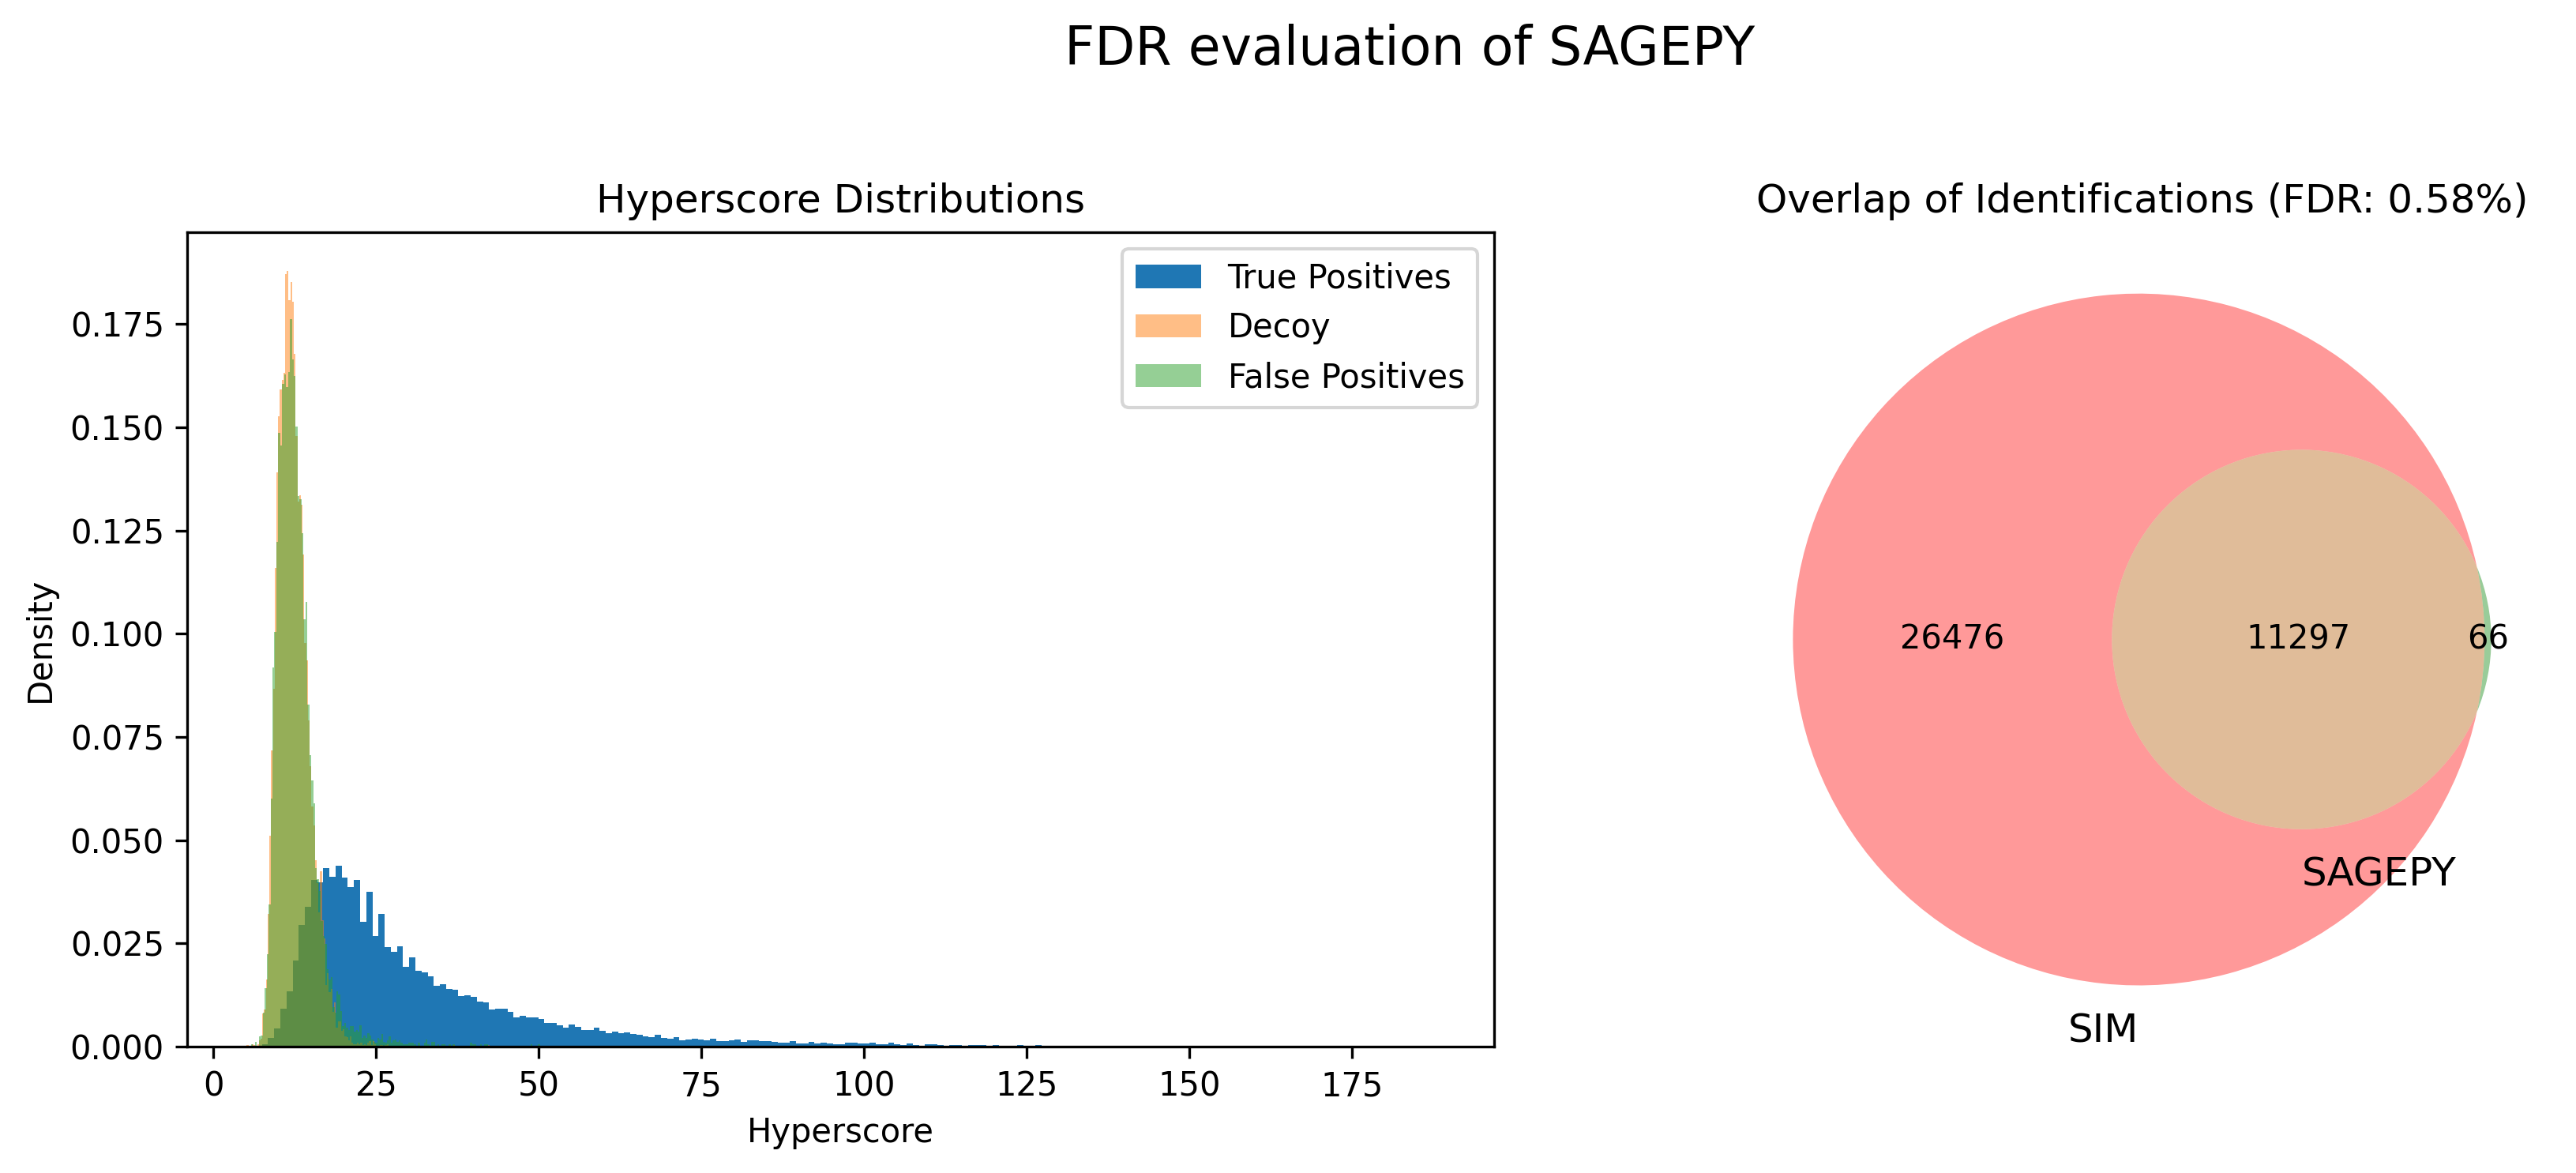

In [153]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
fig.suptitle("FDR evaluation of SAGEPY", fontsize=16)

# Histogram panel (left)
ax1.hist(TP_table[TP_table.decoy == False].hyperscore, density=True, bins="auto", label="True Positives")
ax1.hist(PSM_pandas[PSM_pandas.decoy].hyperscore, density=True, bins="auto", alpha=0.5, label="Decoy")
ax1.hist(TFP_table.hyperscore, density=True, bins="auto", alpha=0.5, label="False Positives")
ax1.set_title("Hyperscore Distributions")
ax1.set_xlabel("Hyperscore")
ax1.set_ylabel("Density")
ax1.legend()

# Venn diagram panel (right)
fdr = np.round((len(SAGEPY.difference(SIM)) / len(SIM.intersection(SAGEPY))) * 100, 2)
venn2([SIM, SAGEPY], ("SIM", "SAGEPY"), ax=ax2)
ax2.set_title(f"Overlap of Identifications (FDR: {fdr}%)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()